# AeroAcoustics.jl
This notebook demonstrates the basic functionality of the AeroAcoustics.jl package.

First obtain a version of julia from https://julialang.org, start the application and run:
```
using Pkg
] add https://gitlab.windenergy.dtu.dk/ollyl/AeroAcoustics.jl.git
```

In [7]:
using Pkg
pkg"add https://gitlab.windenergy.dtu.dk/ollyl/AeroAcoustics.jl.git"
using AeroAcoustics

  Updating git-repo `https://gitlab.windenergy.dtu.dk/ollyl/AeroAcoustics.jl.git`
 Resolving package versions...
  Updating `~/.julia/environments/v1.1/Project.toml`
 [no changes]
  Updating `~/.julia/environments/v1.1/Manifest.toml`
 [no changes]


┌ Info: Recompiling stale cache file /Users/oliver/.julia/compiled/v1.1/AeroAcoustics/M8loF.ji for AeroAcoustics [03ede2b8-90d7-56cb-9af1-359a44c6802d]
└ @ Base loading.jl:1184


Now run the tests to see if everything runs smoothly  
```
]test AeroAcoustics
```
This will start the tests and hopefully you'll see that all tests pass
```
Test Summary: | Pass  Total
AeroAcoustics |    5      5
   Testing AeroAcoustics tests passed
```


The testset downloads to example files, that are store in the .julia directory. Something similar to
```
~/.julia/packages/AeroAcoustics/Dlv4w/test/data
```
Find the files and copy their path.

Now, start by importing the datasets. If it has not previously been added, run
```
]add HDF5
```

In [8]:
using HDF5

In [9]:
srcdir = "/Users/oliver/.julia/packages/AeroAcoustics/Dlv4w/test/data/test1_timeseries.h5"
t = h5read(srcdir, "MicrophoneData/microphoneDataPa")
fs = h5read(srcdir, "MicrophoneData/fs")

65536

Now compute the cross spectral matrix, optionally also add DSP
```
]add DSP
```

In [10]:
using DSP

In [11]:
CSM = csm(t;n=1024,noverlap=div(1024,2),fs=fs,win=DSP.hanning(1024))

84×84×513 AeroAcoustics.FreqArray{Complex{Float32},3,Array{Int64,1}}:
[:, :, 1] =
 2.66121e-6+0.0im  2.64652e-6-0.0im  …  2.38533e-6-0.0im  2.38914e-6-0.0im
 2.64652e-6+0.0im  2.86069e-6+0.0im     2.52108e-6-0.0im  2.59664e-6-0.0im
 2.77127e-6+0.0im  2.87681e-6+0.0im     2.59076e-6-0.0im  2.62928e-6-0.0im
 2.56194e-6+0.0im  2.69676e-6+0.0im     2.45415e-6-0.0im  2.50391e-6-0.0im
 2.59758e-6+0.0im   2.7902e-6+0.0im     2.51077e-6-0.0im  2.59962e-6-0.0im
  2.4884e-6+0.0im  2.56776e-6+0.0im  …  2.31535e-6-0.0im  2.31635e-6-0.0im
 2.46118e-6+0.0im  2.66525e-6+0.0im     2.39819e-6-0.0im  2.47426e-6-0.0im
 2.40262e-6+0.0im  2.61357e-6+0.0im     2.38802e-6-0.0im  2.46106e-6-0.0im
  2.4407e-6+0.0im  2.58418e-6+0.0im     2.36422e-6-0.0im  2.40507e-6-0.0im
 2.39899e-6+0.0im  2.61569e-6+0.0im     2.41221e-6-0.0im  2.47883e-6-0.0im
 2.62182e-6+0.0im  2.83907e-6+0.0im  …  2.60582e-6-0.0im   2.7198e-6-0.0im
 2.52045e-6+0.0im  2.80214e-6+0.0im     2.59111e-6-0.0im   2.7344e-6-0.0im
  2.7905e-6+0.0im 

Now read the microphone geometry and start setting up beamforming

In [13]:
micgeom = h5read(srcdir, "MicrophoneData/arrayGeom")

3×84 Array{Float64,2}:
 -0.16772   -0.36164   -0.37212  -0.57652   …  -0.82407  -0.61627  -0.63689
  0.095093   0.041345   0.20259   0.057883     -0.52936  -0.52079  -0.73896
  0.0        0.0        0.0       0.0           0.0       0.0       0.0    

In [14]:
env = Environment(z0=1.6,
                  micgeom=micgeom,
                  Nx = 21,
                  Ny = 21,
                  flim=(100,10000),
                  xlim=(-0.5,0.5),
                  ylim=(-0.5,0.5),
                  CSM=CSM)

Environment{Float64}
  micgeom: Array{Float64}((3, 84)) [-0.16772 -0.36164 … -0.61627 -0.63689; 0.095093 0.041345 … -0.52079 -0.73896; 0.0 0.0 … 0.0 0.0]
  z0: Float64 1.6
  CSM: AeroAcoustics.FreqArray{Complex{Float32},3,Array{Int64,1}}
  flim: Tuple{Float64,Float64}
  Cinds: BitArray{1}
  fn: Array{Int64}((155,)) [128, 192, 256, 320, 384, 448, 512, 576, 640, 704  …  9408, 9472, 9536, 9600, 9664, 9728, 9792, 9856, 9920, 9984]
  Nf: Int64 155
  Nx: Int64 21
  Ny: Int64 21
  xlim: Tuple{Float64,Float64}
  ylim: Tuple{Float64,Float64}
  c: Float64 343.0
  Ma: Float64 0.0
  M: Int64 84
  N: Int64 441
  rx: StepRangeLen{Float64,Base.TwicePrecision{Float64},Base.TwicePrecision{Float64}}
  ry: StepRangeLen{Float64,Base.TwicePrecision{Float64},Base.TwicePrecision{Float64}}
  Rxy: Array{Float64}((3, 441)) [-0.5 -0.45 … 0.45 0.5; -0.5 -0.5 … 0.5 0.5; 1.6 1.6 … 1.6 1.6]
  D0: Array{Float64}((441,)) [1.74929, 1.73566, 1.72337, 1.71245, 1.70294, 1.69485, 1.68819, 1.683, 1.67929, 1.67705  …  1.6770

Compute steering vectors and beamforming

In [15]:
steeringvectors!(env)
b = beamforming(env)

441×155 Array{Float64,2}:
 5.03454e-5  4.27648e-5  1.83824e-5  4.58198e-6  …  7.26139e-10  6.06478e-10
 5.13365e-5  4.44484e-5  1.96888e-5  5.12762e-6     5.31856e-10  1.60608e-10
 5.22488e-5  4.60178e-5  2.09332e-5  5.66351e-6     2.90578e-9   8.38686e-10
 5.30703e-5  4.7447e-5   2.20878e-5  6.17359e-6     1.31009e-9   7.69514e-10
 5.37897e-5  4.8711e-5   2.3125e-5   6.64112e-6     1.01663e-10  1.37545e-10
 5.43969e-5  4.97862e-5  2.40184e-5  7.04961e-6  …  7.38461e-10  2.98054e-10
 5.48826e-5  5.06519e-5  2.47441e-5  7.38371e-6     2.61129e-9   1.60192e-9 
 5.52392e-5  5.12905e-5  2.52817e-5  7.63018e-6     3.54222e-10  5.99102e-11
 5.54606e-5  5.16882e-5  2.56153e-5  7.77873e-6     1.00045e-9   5.36848e-10
 5.55429e-5  5.1836e-5   2.57343e-5  7.82276e-6     2.25107e-9   7.37183e-10
 5.54838e-5  5.17294e-5  2.56344e-5  7.75982e-6  …  8.44486e-10  2.87447e-10
 5.52836e-5  5.13694e-5  2.53171e-5  7.59182e-6     4.48971e-10  1.98556e-10
 5.49442e-5  5.07616e-5  2.47903e-5  7.3249e-6    

Plot results...

In [16]:
using Plots

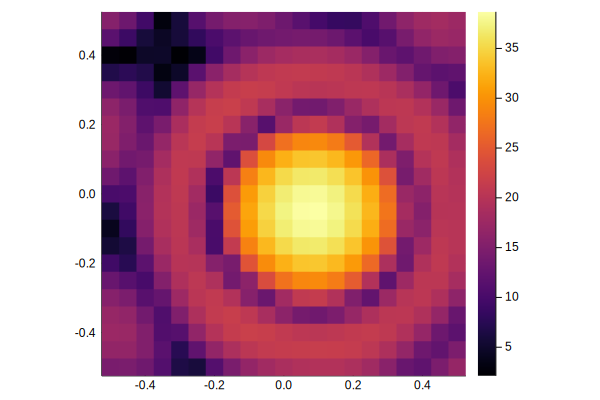

In [17]:
heatmap(env.rx,env.ry,reshape(SPL.(b[:,20]),env.Nx,env.Ny),aspect_ratio=1)